In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)

In [2]:
PROJECT_ID = "taxi-bi-project"
DATASET_ID = "staging"
BQ_LOCATION = "EU"
FULL_DATASET_PREFIX = f"{PROJECT_ID}.{DATASET_ID}"

bq_client = bigquery.Client(project=PROJECT_ID, location=BQ_LOCATION)

In [3]:
TABLE_YELLOW = "yellow_unified"

PICKUP_COL = "tpep_pickup_datetime"
DROPOFF_COL = "tpep_dropoff_datetime"


In [ ]:
def missing_values_yellow(sample_size: int = 10_000) -> pd.DataFrame:

    query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_YELLOW}`
    ORDER BY RAND()
    LIMIT {sample_size}
    """
    df_sample = bq_client.query(query).to_dataframe()

    missing_rate = (
        df_sample.isna()
        .mean()
        .sort_values(ascending=False)
        .to_frame(name="missing_rate")
    )
    missing_rate["sample_size"] = sample_size
    return missing_rate

mv_yellow = missing_values_yellow(sample_size=10_000)
mv_yellow


c:\Users\denni\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,missing_rate,sample_size
Airport_fee,0.7022,10000
congestion_surcharge,0.6456,10000
store_and_fwd_flag,0.2192,10000
RatecodeID,0.0227,10000
passenger_count,0.0227,10000
trip_distance,0.0000,10000
tpep_dropoff_datetime,0.0000,10000
tpep_pickup_datetime,0.0000,10000
VendorID,0.0000,10000
payment_type,0.0000,10000


Die Missing-Value-Analyse basiert auf einem zufälligen Sample von 10.000 Datensätzen und dient der indikativ-explorativen Bewertung der Datenqualität. Entsprechend können die exakten Prozentwerte je nach Stichprobe leicht variieren; die grundsätzlichen Muster bleiben jedoch stabil.

Im Sample zeigen einzelne Spalten erhöhte Missing-Raten. Bei den Yellow-Taxi-Daten betrifft dies insbesondere Attribute, die nur in bestimmten Abrechnungs- oder Nutzungskontexten relevant sind (z. B. optionale Zuschläge, Flags oder Codes). Dies deutet weniger auf zufällige Datenfehler als vielmehr auf strukturelle Unterschiede in der Datenerfassung hin.

Zentrale Analysegrößen wie trip_distance, fare_amount sowie die Pickup- und Dropoff-Zeitstempel sind typischerweise weitgehend vollständig und bilden damit eine geeignete Grundlage für klassische BI-Analysen zu Distanzen, Erlösen und zeitlichen Mustern.

Da die Analyse auf einem Sample basiert, sind die Ergebnisse als indikative Einschätzung zu verstehen. Für eine abschließende Bewertung der Datenqualität sind ergänzende Aggregationen auf Gesamtbestands- oder Metadatenebene erforderlich.

In [5]:
query_yellow_raw = f"""
SELECT
  trip_distance,
  fare_amount,
  {PICKUP_COL} AS pickup_datetime,
  {DROPOFF_COL} AS dropoff_datetime
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_YELLOW}`
ORDER BY RAND()
LIMIT 50000
"""
df_yellow_raw = bq_client.query(query_yellow_raw).to_dataframe()
df_yellow_raw.head()


c:\Users\denni\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,trip_distance,fare_amount,pickup_datetime,dropoff_datetime
0,1.30,6.5,2011-06-28 20:39:59,2011-06-28 20:47:32
1,1.15,7.5,2013-06-30 22:23:00,2013-06-30 22:30:00
2,1.73,12.1,2023-02-17 17:52:50,2023-02-17 18:03:47
3,1.80,9.3,2023-09-20 06:17:46,2023-09-20 06:23:49
4,0.74,5.5,2013-06-21 09:52:00,2013-06-21 09:57:00


Die ersten Datensätze der zufällig gezogenen Yellow-Taxi-Stichprobe zeigen auf den ersten Blick plausible Werte für Fahrtdistanz, Fahrpreis sowie Pickup- und Dropoff-Zeitpunkte. Gleichzeitig wird bereits an dieser Stelle deutlich, dass ohne weitere Prüfungen keine belastbare Aussage über die Datenqualität möglich ist, da Extrem- und Fehlwerte häufig erst bei aggregierter Betrachtung sichtbar werden.

In [6]:
df_yellow = df_yellow_raw.copy()

df_yellow["duration_min"] = (
    df_yellow["dropoff_datetime"] - df_yellow["pickup_datetime"]
).dt.total_seconds() / 60

df_yellow.head()


,trip_distance,fare_amount,pickup_datetime,dropoff_datetime,duration_min
0,1.30,6.5,2011-06-28 20:39:59,2011-06-28 20:47:32,7.55
1,1.15,7.5,2013-06-30 22:23:00,2013-06-30 22:30:00,7.00
2,1.73,12.1,2023-02-17 17:52:50,2023-02-17 18:03:47,10.95
3,1.80,9.3,2023-09-20 06:17:46,2023-09-20 06:23:49,6.05
4,0.74,5.5,2013-06-21 09:52:00,2013-06-21 09:57:00,5.00


Die Fahrtdauer wird als Differenz zwischen Dropoff- und Pickup-Zeitstempel in Minuten berechnet und stellt eine abgeleitete Kennzahl dar, die für zeitliche Analysen relevant ist. Negative oder extrem hohe Fahrtdauern sind nicht ausgeschlossen und werden als potenzielle Indikatoren für fehlerhafte Zeitstempel oder inkonsistente Datensätze verstanden.

In [7]:
df_yellow[["trip_distance", "fare_amount", "duration_min"]].describe()


,trip_distance,fare_amount,duration_min
count,50000.000000,50000.000000,50000.000000
mean,3.129443,14.659158,15.509290
std,3.958635,14.486433,35.451701
min,0.000000,-300.000000,-44.266667
25%,1.040000,7.000000,7.000000
50%,1.800000,10.500000,11.516667
75%,3.300000,16.500000,18.750000
max,137.400000,700.000000,1438.800000


Die deskriptiven Kennzahlen der zentralen Analysegrößen deuten typischerweise auf stark schiefe Verteilungen hin. Während Medianwerte für Distanz, Preis und Dauer im plausiblen Bereich liegen, weisen Minimal- und Maximalwerte häufig auf Extremwerte hin. Diese Ausreißer können Mittelwerte stark verzerren, weshalb Mittelwerte ohne Verteilungsbetrachtung nur eingeschränkt interpretierbar sind.

In [8]:
neg_trip = df_yellow[df_yellow["trip_distance"] < 0]
neg_fare = df_yellow[df_yellow["fare_amount"] < 0]
neg_duration = df_yellow[df_yellow["duration_min"] < 0]

print("Negative Trip Distances:", len(neg_trip))
print("Negative Fare Amounts:", len(neg_fare))
print("Negative Durations:", len(neg_duration))

long_trips = df_yellow[df_yellow["duration_min"] > 180]
print("Sehr lange Fahrten (> 180 Minuten):", len(long_trips))


Negative Trip Distances: 0
Negative Fare Amounts: 237
Negative Durations: 7
Sehr lange Fahrten (> 180 Minuten): 33


Negative Werte (Distanz, Preis oder Dauer) sind fachlich unplausibel und deuten auf fehlerhafte Messungen, Korrekturbuchungen oder inkonsistente Zeitstempel hin. Sehr lange Fahrten (> 3 Stunden) können in Einzelfällen vorkommen, sind im städtischen Taxi-Kontext jedoch untypisch und sollten als Ausreißer separat betrachtet werden, da sie Kennzahlen und Visualisierungen stark verzerren können.

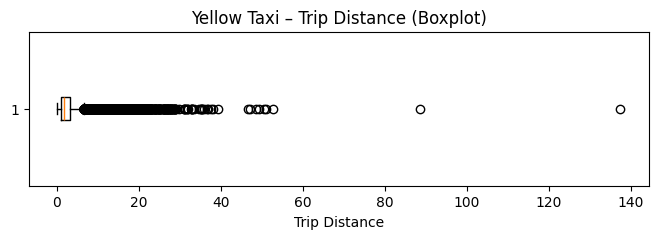

In [9]:
plt.figure(figsize=(8, 2))
plt.boxplot(df_yellow["trip_distance"], vert=False)
plt.title("Yellow Taxi – Trip Distance (Boxplot)")
plt.xlabel("Trip Distance")
plt.show()


Der Boxplot zeigt meist eine stark rechtsschiefe Verteilung mit ausgeprägten Ausreißern. Der zentrale Wertebereich liegt nahe bei kurzen Distanzen, wird jedoch durch extreme Distanzen visuell komprimiert. Für BI-Auswertungen ist es daher essenziell, Ausreißer transparent zu machen und robuste Kennzahlen (Median/Quantile) zu nutzen.

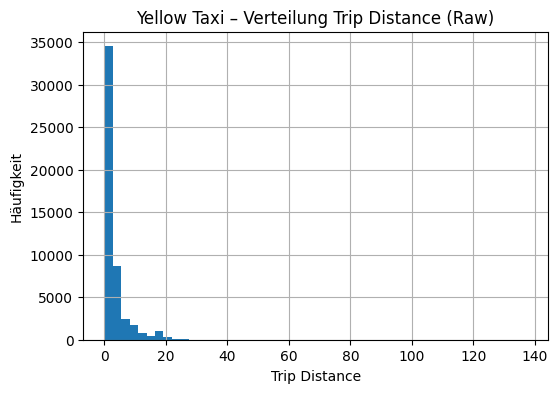

In [10]:
plt.figure(figsize=(6, 4))
df_yellow["trip_distance"].hist(bins=50)
plt.title("Yellow Taxi – Verteilung Trip Distance (Raw)")
plt.xlabel("Trip Distance")
plt.ylabel("Häufigkeit")
plt.show()

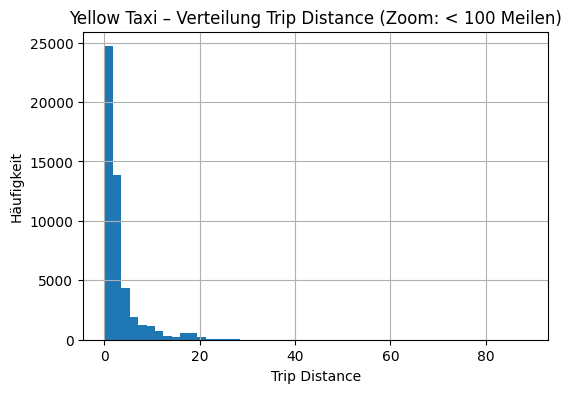

In [11]:
df_yellow_trip_zoom = df_yellow[df_yellow["trip_distance"] < 100]

plt.figure(figsize=(6, 4))
df_yellow_trip_zoom["trip_distance"].hist(bins=50)
plt.title("Yellow Taxi – Verteilung Trip Distance (Zoom: < 100 Meilen)")
plt.xlabel("Trip Distance")
plt.ylabel("Häufigkeit")
plt.show()

In [12]:
df_yellow_trip_outliers = df_yellow[df_yellow["trip_distance"] >= 100]
df_yellow_trip_outliers["trip_distance"].describe()

count      1.0
mean     137.4
std        NaN
min      137.4
25%      137.4
50%      137.4
75%      137.4
max      137.4
Name: trip_distance, dtype: float64

Die Rohdarstellung wird oft durch wenige Extremwerte dominiert. Die Zoom-Sicht macht den relevanten Kernbereich sichtbar, während die separate Outlier-Gruppe zeigt, dass es sich meist um wenige Datensätze mit potenziell unplausiblen Distanzen handelt, die aber starke Auswirkungen auf Kennzahlen haben.

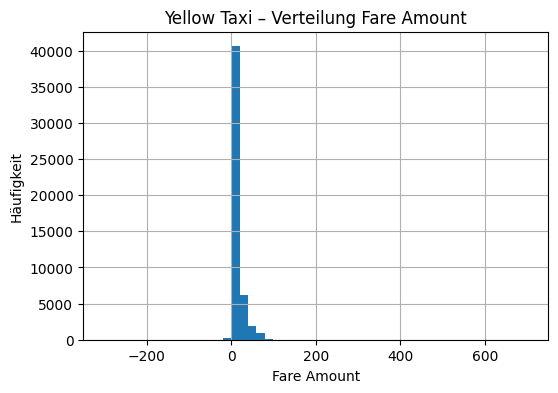

In [13]:
plt.figure(figsize=(6,4))
df_yellow["fare_amount"].hist(bins=50)
plt.title("Yellow Taxi – Verteilung Fare Amount")
plt.xlabel("Fare Amount")
plt.ylabel("Häufigkeit")
plt.show()


Die Fahrpreise sind üblicherweise rechtsschief verteilt. Negative Preise sind unplausibel und deuten auf fehlerhafte Abrechnung/Korrekturen hin. Einzelne sehr hohe Werte verzerren Mittelwerte und sollten gesondert betrachtet werden.

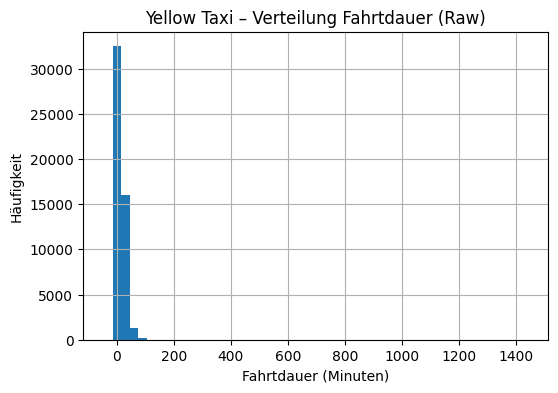

In [14]:
plt.figure(figsize=(6, 4))
df_yellow["duration_min"].hist(bins=50)
plt.title("Yellow Taxi – Verteilung Fahrtdauer (Raw)")
plt.xlabel("Fahrtdauer (Minuten)")
plt.ylabel("Häufigkeit")
plt.show()

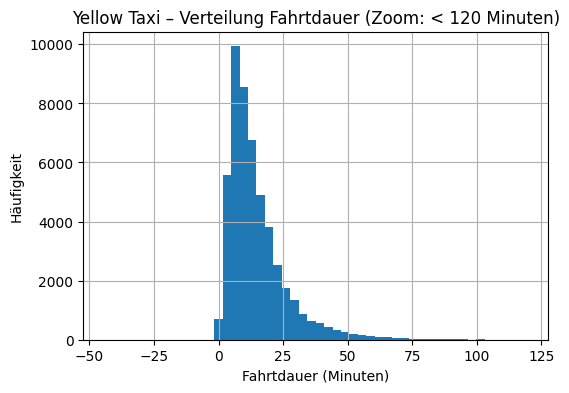

In [15]:
df_yellow_duration_zoom = df_yellow[df_yellow["duration_min"] < 120]
plt.figure(figsize=(6, 4))
df_yellow_duration_zoom["duration_min"].hist(bins=50)
plt.title("Yellow Taxi – Verteilung Fahrtdauer (Zoom: < 120 Minuten)")
plt.xlabel("Fahrtdauer (Minuten)")
plt.ylabel("Häufigkeit")
plt.show()

In [16]:
df_yellow_duration_outliers = df_yellow[df_yellow["duration_min"] >= 120]
df_yellow_duration_outliers["duration_min"].describe()

count      39.000000
mean     1089.553846
std       535.513825
min       123.150000
25%       552.441667
50%      1418.883333
75%      1435.883333
max      1438.800000
Name: duration_min, dtype: float64

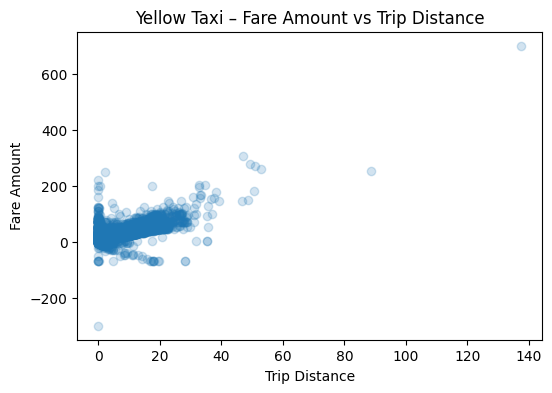

In [17]:
plt.figure(figsize=(6,4))
plt.scatter(df_yellow["trip_distance"], df_yellow["fare_amount"], alpha=0.2)
plt.title("Yellow Taxi – Fare Amount vs Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

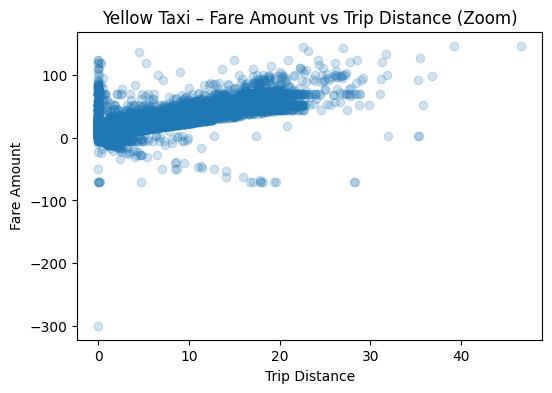

In [18]:
df_yellow_scatter_zoom = df_yellow[
    (df_yellow["trip_distance"] < 100) &
    (df_yellow["fare_amount"] < 150)
]

plt.figure(figsize=(6, 4))
plt.scatter(
    df_yellow_scatter_zoom["trip_distance"],
    df_yellow_scatter_zoom["fare_amount"],
    alpha=0.2
)
plt.title("Yellow Taxi – Fare Amount vs Trip Distance (Zoom)")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

Es ist ein positiver Zusammenhang zwischen Distanz und Preis erkennbar, jedoch mit Streuung durch Zuschläge, Mindestgebühren und weitere Einflussfaktoren. Ausreißer (z. B. sehr hohe Distanz bei moderatem Preis oder negative Preise) sind Indikatoren für Datenqualitätsprobleme.

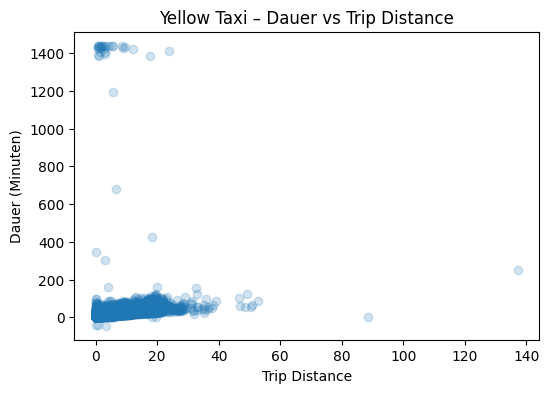

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(df_yellow["trip_distance"], df_yellow["duration_min"], alpha=0.2)
plt.title("Yellow Taxi – Dauer vs Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Dauer (Minuten)")
plt.show()

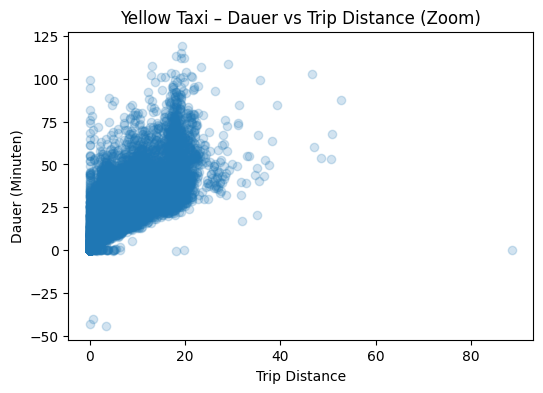

In [20]:
df_yellow_duration_scatter_zoom = df_yellow[
    (df_yellow["trip_distance"] < 100) &
    (df_yellow["duration_min"] < 120)
]

plt.figure(figsize=(6,4))
plt.scatter(
    df_yellow_duration_scatter_zoom["trip_distance"],
    df_yellow_duration_scatter_zoom["duration_min"],
    alpha=0.2
)
plt.title("Yellow Taxi – Dauer vs Trip Distance (Zoom)")
plt.xlabel("Trip Distance")
plt.ylabel("Dauer (Minuten)")
plt.show()

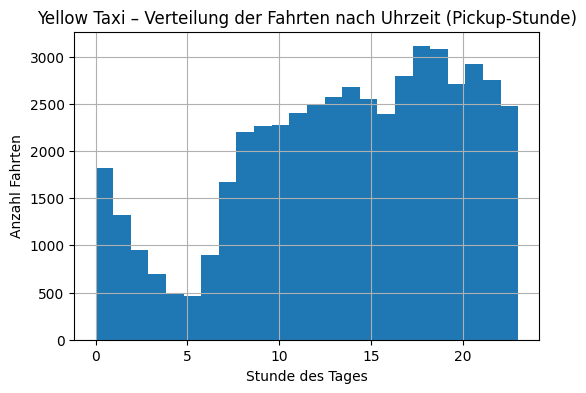

In [21]:
df_yellow["hour"] = pd.to_datetime(df_yellow["pickup_datetime"]).dt.hour

plt.figure(figsize=(6,4))
df_yellow["hour"].hist(bins=24)
plt.title("Yellow Taxi – Verteilung der Fahrten nach Uhrzeit (Pickup-Stunde)")
plt.xlabel("Stunde des Tages")
plt.ylabel("Anzahl Fahrten")
plt.show()


Die stündliche Verteilung zeigt meist klar erkennbare Nachfragepeaks (typisch: Berufsverkehr, Abendstunden, Wochenendnacht). Eine plausibel strukturierte Kurve spricht für grundsätzlich zuverlässige Zeitstempel; Unregelmäßigkeiten können auf Timezone-/Parsing-Probleme oder fehlerhafte Records hinweisen.

# Fazit

Die Data Exploration der Yellow-Taxi-Daten zeigt, dass der Datensatz grundsätzlich für BI-Analysen nutzbar ist, jedoch in zentralen Kennzahlen Auffälligkeiten aufweist. Insbesondere stark rechtsschiefe Verteilungen sowie extreme Ausreißer bei Fahrtdistanz, Fahrtdauer und Fahrpreis können aggregierte Kennzahlen erheblich verzerren. Zusätzlich sind einzelne unplausible Werte (z. B. negative Preise oder inkonsistente Zeitstempel) möglich und sollten im Datenpipeline-Design explizit adressiert werden.

Die ungefilterten Visualisierungen verdeutlichen, dass Mittelwerte ohne zusätzliche Kontextualisierung nur eingeschränkt aussagekräftig sind. Durch ergänzende Zoom-Darstellungen lassen sich plausible Zusammenhänge zwischen Distanz, Dauer und Preis im Kernbereich erkennen, wobei eine hohe Streuung bestehen bleibt.

Für Task 2 ergibt sich daraus die Notwendigkeit, robuste Datenqualitätsmaßnahmen zu implementieren (Schema Enforcement, Outlier-Flagging/Filtering-Regeln, Deduplication und konsistente Typisierung), um verlässliche Kennzahlen und stabile Dashboard-Auswertungen sicherzustellen.